## Use torchcam| for Grad-CAM pretrained is resnet18

In [1]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchcam.methods import GradCAM



# data folder path
data_dir = "/home/kevinluo/breast_density_classification/ultralytics/data_with_muscle"

# pre-processing
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [2]:
# Define Dataset class
class BreastDensityDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []

        for i in range(1, 5):
            class_path = os.path.join(self.data_dir, f"breast_density{i}")
            for img_name in os.listdir(class_path):
                self.img_paths.append(os.path.join(class_path, img_name))
                self.labels.append(i - 1)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
# construct dataset and dataloader
image_datasets = {x: BreastDensityDataset(os.path.join(data_dir, x), data_transforms[x])
                  for x in ["train", "valid", "test"]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ["train", "valid", "test"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid", "test"]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

/home/kevinluo/anaconda3/envs/yolov8/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kevinluo/anaconda3/envs/yolov8/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------


100%|██████████| 953/953 [09:26<00:00,  1.68it/s]


Train Loss: 1.2195 Acc: 0.4659


100%|██████████| 107/107 [00:25<00:00,  4.24it/s]


Valid Loss: 1.5685 Acc: 0.4235
Epoch 2/25
----------


100%|██████████| 953/953 [10:07<00:00,  1.57it/s]


Train Loss: 1.0553 Acc: 0.5302


100%|██████████| 107/107 [00:24<00:00,  4.30it/s]


Valid Loss: 1.1177 Acc: 0.4800
Epoch 3/25
----------


100%|██████████| 953/953 [10:27<00:00,  1.52it/s]


Train Loss: 0.9874 Acc: 0.5567


100%|██████████| 107/107 [00:26<00:00,  4.09it/s]


Valid Loss: 1.4254 Acc: 0.4353
Epoch 4/25
----------


100%|██████████| 953/953 [10:22<00:00,  1.53it/s]


Train Loss: 0.9417 Acc: 0.5892


100%|██████████| 107/107 [00:24<00:00,  4.32it/s]


Valid Loss: 0.9911 Acc: 0.5741
Epoch 5/25
----------


100%|██████████| 953/953 [10:28<00:00,  1.52it/s]


Train Loss: 0.8957 Acc: 0.6121


100%|██████████| 107/107 [00:25<00:00,  4.27it/s]


Valid Loss: 0.8387 Acc: 0.6400
Epoch 6/25
----------


100%|██████████| 953/953 [10:23<00:00,  1.53it/s]


Train Loss: 0.8827 Acc: 0.6142


100%|██████████| 107/107 [00:25<00:00,  4.24it/s]


Valid Loss: 0.7212 Acc: 0.6918
Epoch 7/25
----------


100%|██████████| 953/953 [10:23<00:00,  1.53it/s]


Train Loss: 0.8335 Acc: 0.6475


100%|██████████| 107/107 [00:25<00:00,  4.26it/s]


Valid Loss: 1.2037 Acc: 0.4306
Epoch 8/25
----------


100%|██████████| 953/953 [10:21<00:00,  1.53it/s]


Train Loss: 0.6958 Acc: 0.7150


100%|██████████| 107/107 [00:25<00:00,  4.25it/s]


Valid Loss: 0.7329 Acc: 0.6894
Epoch 9/25
----------


100%|██████████| 953/953 [10:20<00:00,  1.54it/s]


Train Loss: 0.6678 Acc: 0.7315


100%|██████████| 107/107 [00:25<00:00,  4.28it/s]


Valid Loss: 0.7229 Acc: 0.7106
Epoch 10/25
----------


100%|██████████| 953/953 [10:24<00:00,  1.53it/s]


Train Loss: 0.6612 Acc: 0.7344


100%|██████████| 107/107 [00:25<00:00,  4.27it/s]


Valid Loss: 0.7059 Acc: 0.7129
Epoch 11/25
----------


100%|██████████| 953/953 [10:25<00:00,  1.52it/s]


Train Loss: 0.6406 Acc: 0.7407


100%|██████████| 107/107 [00:25<00:00,  4.15it/s]


Valid Loss: 0.6961 Acc: 0.7082
Epoch 12/25
----------


100%|██████████| 953/953 [10:24<00:00,  1.53it/s]


Train Loss: 0.6391 Acc: 0.7457


100%|██████████| 107/107 [00:24<00:00,  4.31it/s]


Valid Loss: 0.7043 Acc: 0.7106
Epoch 13/25
----------


100%|██████████| 953/953 [10:18<00:00,  1.54it/s]


Train Loss: 0.6225 Acc: 0.7525


100%|██████████| 107/107 [00:24<00:00,  4.38it/s]


Valid Loss: 0.7021 Acc: 0.7176
Epoch 14/25
----------


100%|██████████| 953/953 [10:19<00:00,  1.54it/s]


Train Loss: 0.6170 Acc: 0.7559


100%|██████████| 107/107 [00:25<00:00,  4.26it/s]


Valid Loss: 0.7063 Acc: 0.7153
Epoch 15/25
----------


100%|██████████| 953/953 [10:18<00:00,  1.54it/s]


Train Loss: 0.5824 Acc: 0.7793


100%|██████████| 107/107 [00:25<00:00,  4.26it/s]


Valid Loss: 0.6939 Acc: 0.7059
Epoch 16/25
----------


100%|██████████| 953/953 [10:22<00:00,  1.53it/s]


Train Loss: 0.5814 Acc: 0.7724


100%|██████████| 107/107 [00:25<00:00,  4.26it/s]


Valid Loss: 0.6424 Acc: 0.7388
Epoch 17/25
----------


100%|██████████| 953/953 [10:24<00:00,  1.53it/s]


Train Loss: 0.5734 Acc: 0.7840


100%|██████████| 107/107 [00:26<00:00,  4.11it/s]


Valid Loss: 0.6547 Acc: 0.7529
Epoch 18/25
----------


100%|██████████| 953/953 [10:34<00:00,  1.50it/s]


Train Loss: 0.5697 Acc: 0.7837


100%|██████████| 107/107 [00:25<00:00,  4.19it/s]


Valid Loss: 0.6861 Acc: 0.7341
Epoch 19/25
----------


100%|██████████| 953/953 [10:31<00:00,  1.51it/s]


Train Loss: 0.5900 Acc: 0.7654


100%|██████████| 107/107 [00:25<00:00,  4.23it/s]


Valid Loss: 0.6455 Acc: 0.7435
Epoch 20/25
----------


100%|██████████| 953/953 [10:29<00:00,  1.51it/s]


Train Loss: 0.5654 Acc: 0.7858


100%|██████████| 107/107 [00:25<00:00,  4.27it/s]


Valid Loss: 0.6893 Acc: 0.7294
Epoch 21/25
----------


100%|██████████| 953/953 [10:20<00:00,  1.54it/s]


Train Loss: 0.5756 Acc: 0.7743


100%|██████████| 107/107 [00:24<00:00,  4.32it/s]


Valid Loss: 0.6232 Acc: 0.7459
Epoch 22/25
----------


100%|██████████| 953/953 [10:24<00:00,  1.53it/s]


Train Loss: 0.5649 Acc: 0.7856


100%|██████████| 107/107 [00:25<00:00,  4.27it/s]


Valid Loss: 0.6714 Acc: 0.7341
Epoch 23/25
----------


100%|██████████| 953/953 [10:26<00:00,  1.52it/s]


Train Loss: 0.5663 Acc: 0.7913


100%|██████████| 107/107 [00:24<00:00,  4.40it/s]


Valid Loss: 0.6979 Acc: 0.7365
Epoch 24/25
----------


100%|██████████| 953/953 [10:31<00:00,  1.51it/s]


Train Loss: 0.5552 Acc: 0.7858


100%|██████████| 107/107 [00:24<00:00,  4.31it/s]


Valid Loss: 0.6426 Acc: 0.7388
Epoch 25/25
----------


100%|██████████| 953/953 [10:26<00:00,  1.52it/s]


Train Loss: 0.5646 Acc: 0.7840


100%|██████████| 107/107 [00:24<00:00,  4.42it/s]


Valid Loss: 0.6490 Acc: 0.7482
Training complete in 269m 35s
Best validation Acc: 0.7529


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

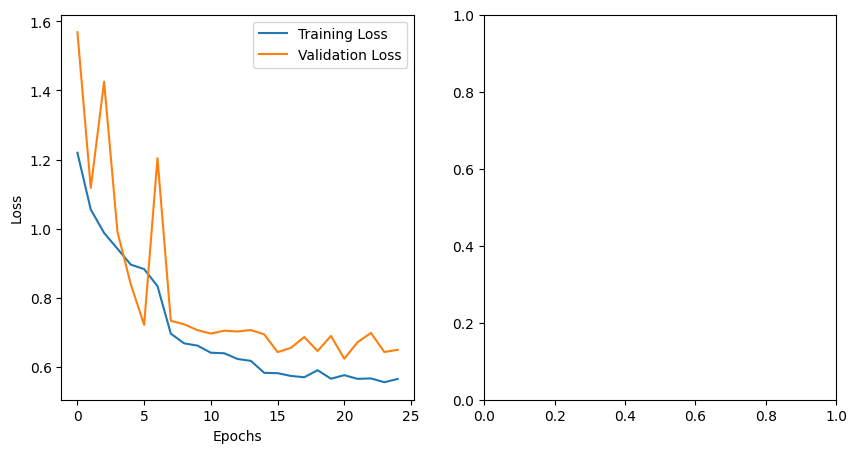

In [5]:
# define training function
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_acc.append(epoch_acc)

            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, train_acc, valid_acc

# begin train
num_epochs = 25
model, train_losses, valid_losses, train_acc, valid_acc = train_model(model, criterion, optimizer, scheduler, num_epochs)

# plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [ ]:
torch.save(model.state_dict(), "0510GradCAM.pth") # 只保存模型的参数
torch.save(model, "0510GradCAM.pth") # 保存整个模型

## Grad-CAM

In [ ]:
# Grad-CAM function
def create_heatmap(img_path, model):
    img = Image.open(img_path).convert("RGB")
    transformed_img = data_transforms["valid"](img).unsqueeze(0)

    model.eval()
    inputs = transformed_img.to(device)
    inputs = Variable(inputs, requires_grad=True)
    outputs = model(inputs)
    _, preds =     _, preds = torch.max(outputs, 1)

    # 使用 Grad-CAM 生成熱圖
    cam_extractor = GradCAM(model, model.layer4[-1])
    activation_map = cam_extractor(inputs, preds)

    # 將熱圖疊加到原始圖像上
    heatmap = cv2.applyColorMap(activation_map.cpu().numpy(), cv2.COLORMAP_JET)
    image = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    result = heatmap * 0.3 + image * 0.5

    # 顯示原始圖像和熱圖
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.figure()
    plt.imshow(cv2.cvtColor(result.astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.title("Heatmap")
    plt.axis("off")

    plt.show()

# 選擇一個圖像進行可視化
img_path = "/home/kevinluo/breast_density_classification/ultralytics/data_with_muscle/valid/breast_density1/P_01849_RIGHT_MLO_1_0_1_jpg.rf.77626fbdc0a694001e04f57e2f6a5010.jpg"
create_heatmap(img_path, model)
## 請將img_path替換為您要可視化的圖像路徑。這段代碼將讀取圖像，將其輸入到模型中，
## 使用 Grad-CAM 生成熱圖，並將熱圖疊加到原始圖像上。